In [507]:
import tensorflow as tf 
import os
from random import shuffle
import numpy as np
import os.path
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sb
from PIL import Image

In [508]:
os.chdir('/data')
working_directory = os.getcwd()
print("working directory:", working_directory)

working directory: /data


# 1. Loading Data and Preprocessing

In [509]:
def make_image_df(folder):
    test_image_dir = Path('fish_data/'+folder)
    test_filepaths = list(test_image_dir.glob(r'*/*.*'))
    test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepaths))

    test_filepaths = pd.Series(test_filepaths, name='Filepath').astype(str)
    test_labels = pd.Series(test_labels, name='Label')
    test_image_df = pd.concat([test_filepaths, test_labels], axis=1)
    return test_image_df

test_df = make_image_df('Test')
dev_df = make_image_df('Train_Val')
total_df = pd.concat([dev_df, test_df], axis=0, ignore_index=True)
total_df = total_df.sample(frac = 1, ignore_index=True, random_state = 32) # Adding extra shuffling/randomness for img visualization

In [510]:
print(total_df.head())
print(total_df.shape)

                                        Filepath            Label
0  fish_data/Train_Val/Gilt Head Bream/00861.png  Gilt Head Bream
1   fish_data/Train_Val/Horse Mackerel/00813.png   Horse Mackerel
2  fish_data/Train_Val/Gilt Head Bream/00440.png  Gilt Head Bream
3       fish_data/Train_Val/Red Mullet/00420.png       Red Mullet
4         fish_data/Train_Val/Sea Bass/00030.png         Sea Bass
(9447, 2)


In [511]:
# 10% Test, 20% Validation, 70% Training
# Stratification is not needed as the classes are balanced
dev_df, test_df = train_test_split(total_df, test_size=0.1, train_size=0.9, shuffle=True, random_state=42)
train_df, val_df = train_test_split(dev_df, test_size=0.2, train_size=0.8, shuffle=True, random_state=42)

In [512]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255 # Min-max normalization, data augmentation has already been performed
)

In [513]:
train_images = image_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True, # Inducing additional randomization
    seed=42
)

val_images = image_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True, # Shuffling has no impact here (would not effect results if set to False)
    seed=42
)

test_images = image_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False, # Not shuffling in order to display evaluation metrics
    seed=42
)

Found 6789 validated image filenames belonging to 9 classes.
Found 1698 validated image filenames belonging to 9 classes.
Found 943 validated image filenames belonging to 9 classes.


/root/yes/envs/tensorflow/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 12 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/root/yes/envs/tensorflow/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(
/root/yes/envs/tensorflow/lib/python3.9/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 2 invalid image filename(s) in x_col="Filepath". These filename(s) will be ignored.
  warnings.warn(


In [533]:
print("Training images:", train_images.samples, "\nTraining image shape:", train_images.image_shape)
print("Validation images:", val_images.samples, "\nValidation image shape:", val_images.image_shape)
print("Test images:", test_images.samples, "\nTest image shape:", test_images.image_shape)

Training images: 6789 
Training image shape: (224, 224, 3)
Validation images: 1698 
Validation image shape: (224, 224, 3)
Test images: 943 
Test image shape: (224, 224, 3)


In [515]:
train_images.class_indices

{'Black Sea Sprat': 0,
 'Gilt Head Bream': 1,
 'Horse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [516]:
val_images.class_indices

{'Black Sea Sprat': 0,
 'Gilt Head Bream': 1,
 'Horse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [517]:
test_images.class_indices

{'Black Sea Sprat': 0,
 'Gilt Head Bream': 1,
 'Horse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

## 1.1 Visualizing Data

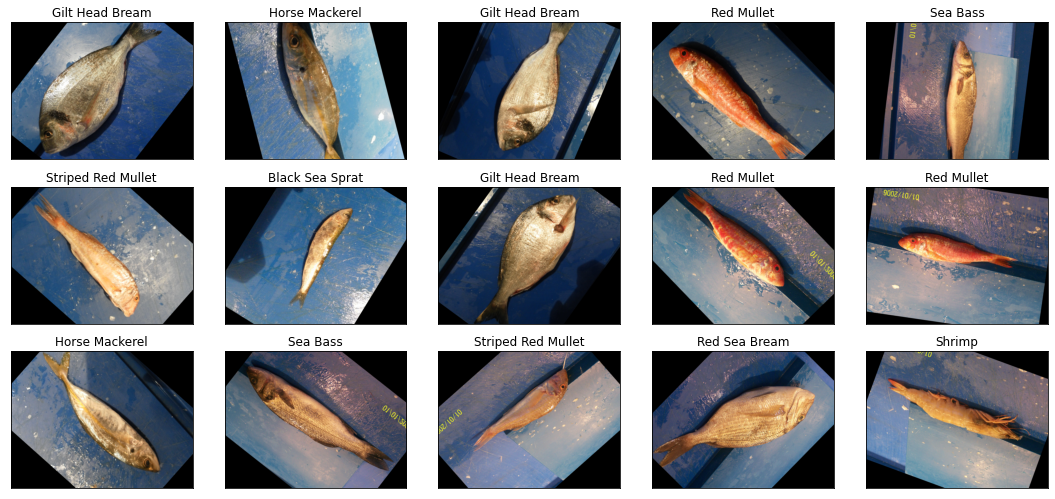

In [518]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(mpimg.imread(total_df.loc[i, 'Filepath']))
    ax.set_title(total_df.loc[i, 'Label'])
    
plt.tight_layout()
plt.show();

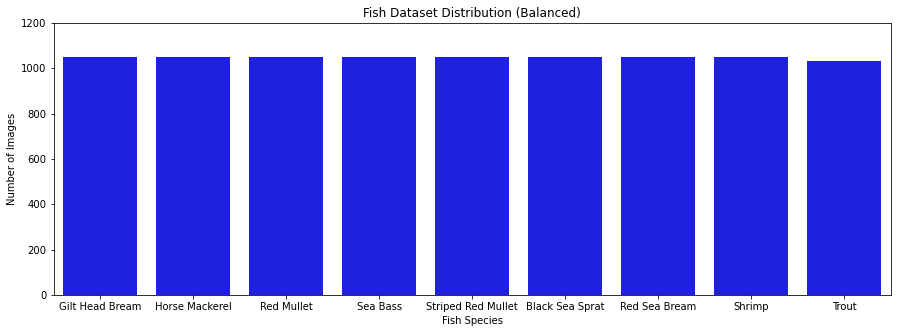

In [519]:
plt.figure(figsize=(15,5))
sb.countplot(x=total_df.Label, color='blue')
plt.ylim(top=1200)
plt.title("Fish Dataset Distribution (Balanced)")
plt.xlabel("Fish Species")
plt.ylabel("Number of Images");

# 2. Defining Model Architecture

In [520]:
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [521]:
input = Input(shape =(224,224,3))
l1 = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(input)
l2 = MaxPool2D(2,2)(l1)
l3 = Dropout(0.2)(l2)

# Regularizing using penalty instead of dropout (want to maintain feature extraction capabilities)
l4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2=0.001))(l3) 
l5 = MaxPool2D(2,2)(l4)
l6 = Flatten()(l5)

l7 = Dense(256, activation='relu')(l6)
l8 = Dropout(0.2)(l7) 
l9 = Dense(256, activation='relu')(l8)
l10 = Dropout(0.2)(l9) 
output = Dense(9, activation='softmax')(l10)

model = Model (inputs=input, outputs =output)
model.compile(
    optimizer='adam', # Starting learning rate of 0.001 (default parameter)
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model_232"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 64)      73792     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 186624)            0 

# 3. Defining Schedulers and Callbacks

In [522]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10) # Fine tune
checkpoint_path = "training_1/cp.ckpt"
monitor = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                                             verbose=1,save_best_only=True,
                                             save_weights_only=True,
                                             mode='min') # Only saves the best model (so far) in terms of min validation loss

def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/1.2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)
lr_schedule_on_plateau = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1)
callbacks = [early_stop, monitor, lr_schedule_on_plateau,lr_schedule]

# 4. Training Model - *skip unless optimizing*

In [53]:
try:
    history = model.fit(
        train_images, 
        validation_data=val_images, 
        epochs=50, # Fine tune
        callbacks=callbacks
    )
except KeyboardInterrupt:
    print("\nmodel training terminated\n")

Epoch 1/50
213/213 [==============================] - 123s 575ms/step - loss: 2.2015 - accuracy: 0.4024 - val_loss: 0.5507 - val_accuracy: 0.8264

Epoch 00001: val_loss improved from inf to 0.55074, saving model to training_1/cp.ckpt
Epoch 2/50
213/213 [==============================] - 109s 513ms/step - loss: 0.2979 - accuracy: 0.9177 - val_loss: 0.2720 - val_accuracy: 0.9229

Epoch 00002: val_loss improved from 0.55074 to 0.27203, saving model to training_1/cp.ckpt
Epoch 3/50
213/213 [==============================] - 108s 504ms/step - loss: 0.0942 - accuracy: 0.9851 - val_loss: 0.2470 - val_accuracy: 0.9247

Epoch 00003: val_loss improved from 0.27203 to 0.24697, saving model to training_1/cp.ckpt
Epoch 4/50
213/213 [==============================] - 107s 503ms/step - loss: 0.0766 - accuracy: 0.9891 - val_loss: 0.2086 - val_accuracy: 0.9453

Epoch 00004: val_loss improved from 0.24697 to 0.20862, saving model to training_1/cp.ckpt
Epoch 5/50
213/213 [==============================] 

In [ ]:
np.save('history.npy', history.history)

# 5. Loading/Saving Best Model and Testing

In [523]:
model.load_weights(checkpoint_path)

In [480]:
model.save('Model')

INFO:tensorflow:Assets written to: Model/assets


In [481]:
history=np.load('history.npy', allow_pickle='TRUE').item() # Get standard scalar object
print("All training results", history)

All training results {'loss': [1.2918709516525269, 0.30588680505752563, 0.1398799866437912, 0.0918986052274704, 0.0747467502951622, 0.05734184756875038, 0.05725032091140747, 0.072073794901371, 0.046092379838228226, 0.04909295216202736, 0.027461392804980278, 0.024308525025844574, 0.020618436858057976, 0.01864658296108246, 0.017741279676556587, 0.01764005608856678, 0.01673857495188713, 0.016180915758013725, 0.01548372209072113, 0.015170665457844734, 0.015041062608361244, 0.014333194121718407, 0.013551276177167892, 0.013165684416890144, 0.013172327540814877, 0.012194763869047165, 0.012850886210799217, 0.011144140735268593, 0.010956073179841042, 0.010202297009527683, 0.01004001498222351, 0.00980854406952858, 0.009938756003975868, 0.009602274745702744, 0.009361282922327518, 0.0092219989746809], 'accuracy': [0.5773195624351501, 0.9141384363174438, 0.9702503681182861, 0.9846833348274231, 0.9883652329444885, 0.9924889802932739, 0.9929307699203491, 0.9865979552268982, 0.9938144087791443, 0.9927

In [482]:
val_loss_indx= np.argmin(history.get('val_loss')) # Find list-val index with minimum validation loss (optimum saved based on callback)
print("Best Training Results (minimum validation loss):\n")
print("Training Loss: {:.2f}\nValidation Loss: {:.2f}\nTraining Accuracy: {:.2f}%\nValidation Accuracy: {:.2f}%\n".format(history.get('loss')[val_loss_indx], 
                                                                                                        history.get('val_loss')[val_loss_indx], 
                                                                                                        100*history.get('accuracy')[val_loss_indx], 
                                                                                                        100*history.get('val_accuracy')[val_loss_indx]))

Best Training Results (minimum validation loss):

Training Loss: 0.01
Validation Loss: 0.09
Training Accuracy: 99.99%
Validation Accuracy: 97.53%



# 6. Training and Validation Curves

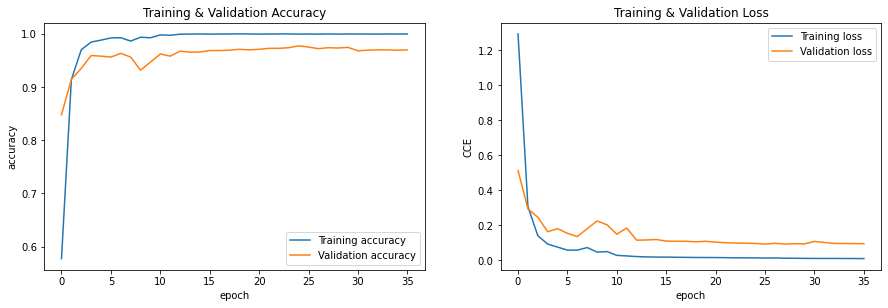

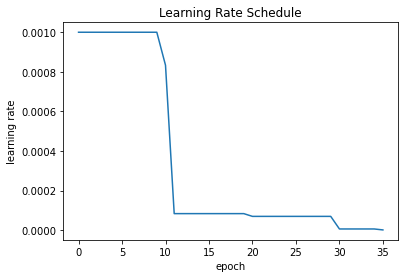

In [483]:
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']
lr = history['lr']

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.xlabel("epoch")
plt.ylabel("CCE")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

plt.plot(lr)
plt.xlabel("epoch")
plt.ylabel("learning rate")
plt.title("Learning Rate Schedule")
plt.show();

# 7. Model Evaluation and Classification Reports

In [484]:
results = model.evaluate(test_images, verbose=1)

print("Categorical Cross Entropy: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

30/30 [==============================] - 13s 421ms/step - loss: 0.0290 - accuracy: 0.9924
Categorical Cross Entropy: 0.03666
Test Accuracy: 99.26%


In [485]:
pred_labels_num = np.argmax(model.predict(test_images), axis=1)

In [486]:
labels_dic = dict(zip(list(range(0,9)), list(train_images.class_indices.keys())))

In [487]:
pred_labels = [labels_dic.get(x) for x in pred_labels_num]
true_labels = [labels_dic.get(x) for x in test_images.labels]

In [488]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      0.99      0.99        99
   Gilt Head Bream       1.00      0.99      1.00       115
    Horse Mackerel       0.99      0.99      0.99       100
        Red Mullet       0.99      1.00      0.99        93
     Red Sea Bream       1.00      0.99      1.00       105
          Sea Bass       0.97      1.00      0.99       117
            Shrimp       1.00      0.98      0.99       111
Striped Red Mullet       0.98      0.99      0.99       111
             Trout       1.00      1.00      1.00        92

          accuracy                           0.99       943
         macro avg       0.99      0.99      0.99       943
      weighted avg       0.99      0.99      0.99       943



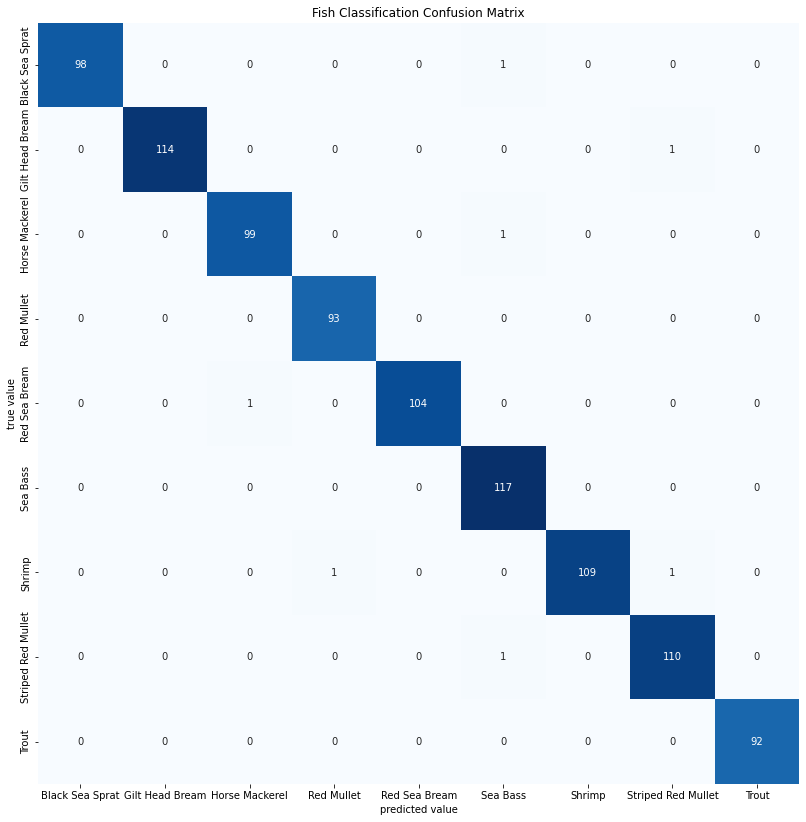

In [489]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(true_labels, pred_labels, labels=list(train_images.class_indices.keys()))
plt.subplots(figsize=[14,14])
sb.heatmap(matrix, xticklabels=list(train_images.class_indices.keys()),  
            yticklabels=list(train_images.class_indices.keys()), 
            square=True, annot=True, cbar=False, fmt='d', cmap='Blues')
plt.xlabel('predicted value')
plt.ylabel('true value')
plt.title(label = "Fish Classification Confusion Matrix");

# 7.1 Missclassified Samples

Only 7 fish samples were classified incorrectly!


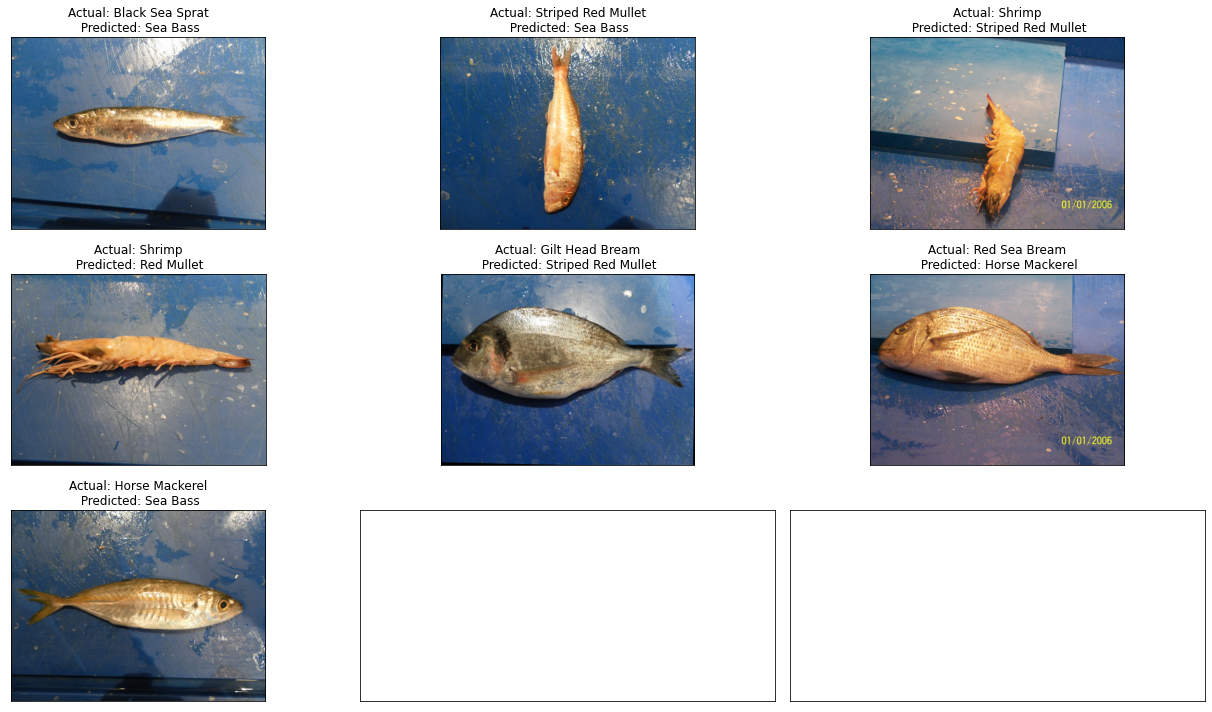

In [547]:
missclass_ind =[index for index, elem in enumerate(pred_labels_num)
                           if elem != test_images.labels[index]]
print("Only", len(missclass_ind), "fish samples were classified incorrectly!")

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(test_images.filepaths[missclass_ind[i]]))
    img_title = "Actual: {}\n Predicted: {}".format(true_labels[missclass_ind[i]], pred_labels[missclass_ind[i]])
    ax.set_title(img_title)
    if i == len(missclass_ind)-1:
        break
    
plt.tight_layout()
plt.show();

# 8. GradCam Analysismissclass_ind

In [459]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

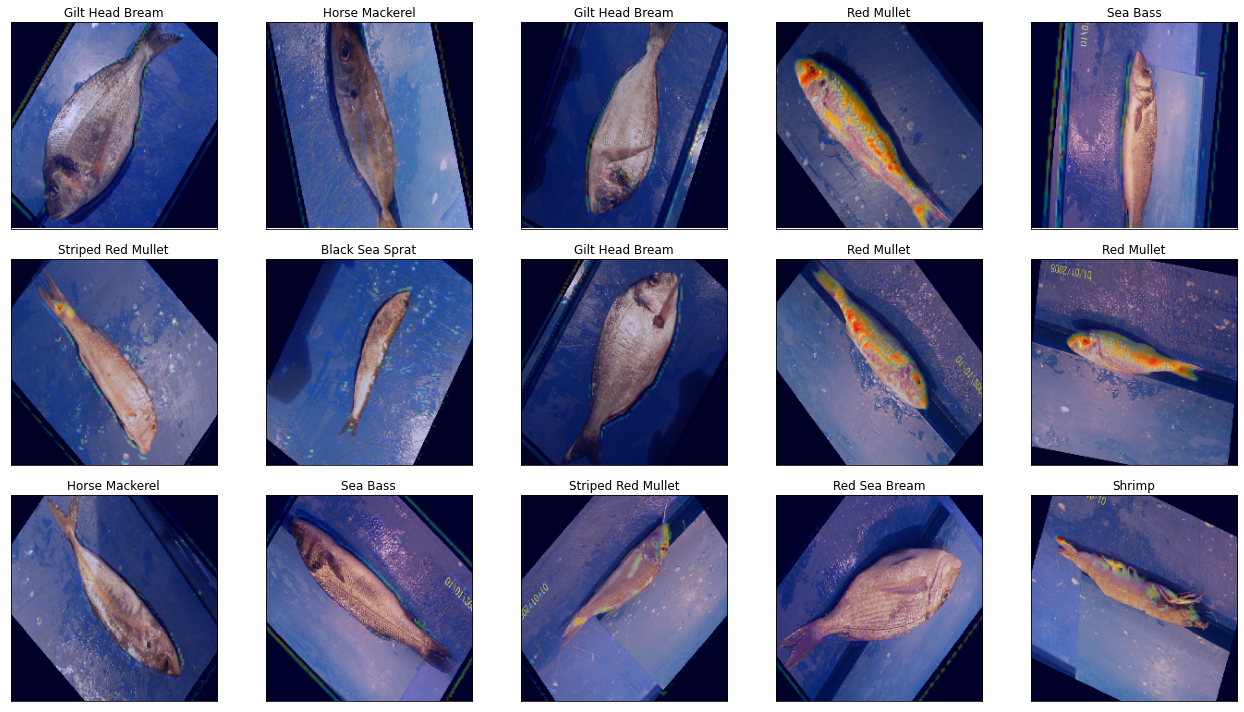

In [461]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    test_img = get_img_array(total_df.loc[i, 'Filepath'], (224,224))
    test_heatmap = make_gradcam_heatmap(test_img, model, "conv2d_9")
    ax.imshow(save_and_display_gradcam(test_img.reshape(224,224,3), test_heatmap))
    ax.set_title(total_df.loc[i, 'Label'])
    
plt.tight_layout()
plt.show();